In [15]:
%%capture
%pip install librosa scikit-learn matplotlib datasets plotly pandas transformers

In [1]:
import pandas as pd
# df = pd.read_csv('/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs_19.csv')
df = pd.read_csv('/home/ec2-user/SageMaker/stt-model-evaluation/tsv/05_benchmark.csv')

In [2]:
df = df[['file_name', 'audio_len', 'uni', 'url', 'dept']]
# df = df[['file_name', 'audio_duration', 'inference_transcript', 'url']]

In [3]:
# df = df.head(500)
len(df)

5366

In [5]:
df['file_path'] = df['file_name'].apply( lambda x: f"/home/ec2-user/SageMaker/downloaded_audio/{x}.wav")
# df['file_path'] = df['file_name'].apply( lambda x: f"/home/ec2-user/SageMaker/stt-split-audio/STT_HS/segments_hs/{x}.wav")

In [6]:
from datasets import Dataset
dataset = Dataset.from_pandas(df)

In [8]:
from datasets import Dataset
import pandas as pd
from transformers import Wav2Vec2Processor, Wav2Vec2Model
import librosa
import numpy as np
import torch

# Initialize the processor and model spsither/wav2vec2_run10.840
processor = Wav2Vec2Processor.from_pretrained("spsither/wav2vec2_run10.1055")
model = Wav2Vec2Model.from_pretrained("spsither/wav2vec2_run10.1055")

# Define a function to load and preprocess audio
def preprocess_audio(batch):
    speech_array, sampling_rate = librosa.load(batch["file_path"], sr=16000)
    batch["speech"] = speech_array
    batch["sampling_rate"] = sampling_rate
    return batch

# Define a function for feature extraction
def extract_features(batch):
    # Process the batch of audio inputs
    inputs = processor(batch["speech"], sampling_rate=16000, return_tensors="pt", padding=True)

    # Move the batch to the same device as the model
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    # Extract features
    with torch.no_grad():
        features = model(**inputs).last_hidden_state

    # Convert features to numpy and take the mean across the time dimension
    batch["features"] = features.cpu().numpy().mean(axis=1)
    return batch

# Assuming df is your DataFrame and it has a column 'file_path' with the audio file paths
# Convert the DataFrame to a Hugging Face Dataset
dataset = Dataset.from_pandas(df)

# Apply preprocessing to load the audio files
dataset = dataset.map(preprocess_audio, batched=False)  # Process files individually to load audio

# Extract features in batches
dataset = dataset.map(extract_features, batched=True, batch_size=8)

# Convert the extracted features into a numpy array
features_array = np.array(dataset["features"])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Parameter 'function'=<function extract_features at 0x7f3dd7510d30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [11]:
print('done')

done


In [12]:
# np.save('05_benchmark_features_array.npy', features_array)
np.save('hs_500_features_array.npy', features_array)

In [8]:
import numpy as np
features_array = np.load('05_benchmark_features_array.npy')
# features_array = np.load('hs_500_features_array.npy')

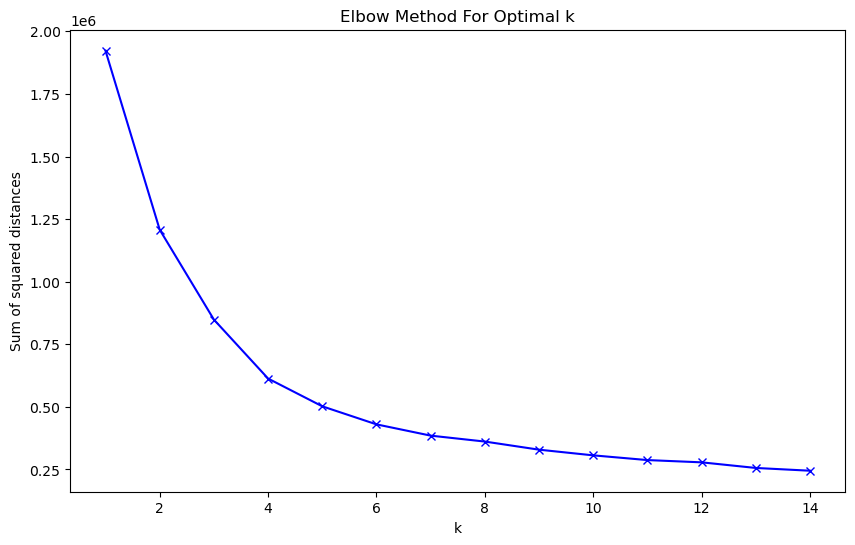

In [9]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

# Assuming 'features_array' is your data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)
pca = PCA(n_components=3)  # Reducing to 3 dimensions for visualization
reduced_features = pca.fit_transform(features_scaled)

# Elbow method to find the optimal number of clusters
sum_of_squared_distances = []
K = range(1, 15)  # You can adjust the range of k here based on your dataset size and complexity
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(reduced_features)
    sum_of_squared_distances.append(km.inertia_)

# Plotting the elbow plot
plt.figure(figsize=(10, 6))
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [15]:
n_clusters = 4 # Adjust based on your needs

In [16]:
import plotly.express as px
import pandas as pd

# Assuming 'reduced_features' is your data and 'labels' are your cluster labels
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)
pca = PCA(n_components=3)  # Change to 3 dimensions for visualization
reduced_features = pca.fit_transform(features_scaled)

# Clustering
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(reduced_features)
labels = kmeans.labels_

# Convert your data into a DataFrame for easier handling
df_plot = pd.DataFrame(reduced_features, columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
df_plot['Cluster'] = labels

# Create an interactive 3D scatter plot
fig = px.scatter_3d(df_plot, x='PCA Component 1', y='PCA Component 2', z='PCA Component 3',
                    color='Cluster', color_continuous_scale='viridis',
                    title='Clustered Audio Segments using wav2vec2 Features in 3D')

fig.update_layout(width=900, height=700) # You can adjust these values according to your needs

fig.show()

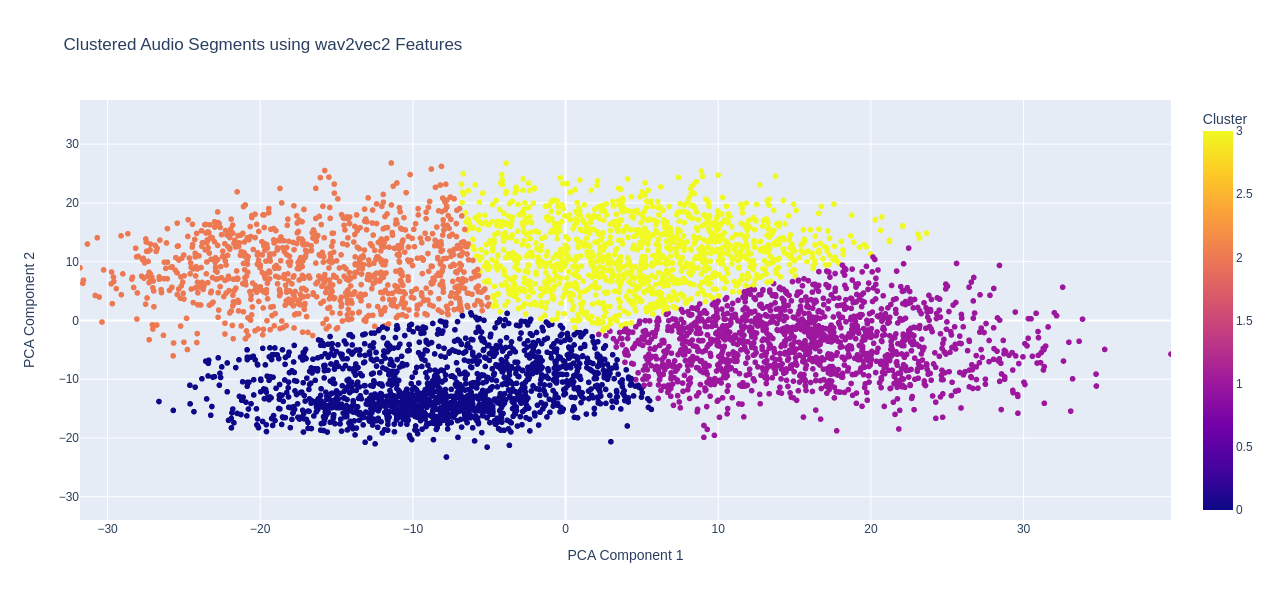

In [17]:
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

# Your data preparation steps remain the same
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_array)
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(features_scaled)

kmeans = KMeans(n_clusters=n_clusters)  # Adjust based on your needs
kmeans.fit(reduced_features)
labels = kmeans.labels_

# Assuming 'df' is your DataFrame and it includes a column 'file_name' that corresponds to each point
# You need to create a DataFrame that includes your PCA components, labels, and file names
df_plot = pd.DataFrame(reduced_features, columns=['PCA Component 1', 'PCA Component 2'])
df_plot['Cluster'] = labels
df_plot['file_name'] = df['file_name']  # Make sure 'df' has the 'file_name' you want to display

# Step 1: Determine the range of your data
x_range = [df_plot['PCA Component 1'].min(), df_plot['PCA Component 1'].max()]
y_range = [df_plot['PCA Component 2'].min(), df_plot['PCA Component 2'].max()]

# Step 2: Calculate the maximum range
max_range = max(x_range[1] - x_range[0], y_range[1] - y_range[0])

# Step 3: Center your data
x_center = np.mean(x_range)
y_center = np.mean(y_range)

# Step 4: Set your axis ranges equally
x_axis_range = [x_center - max_range / 2, x_center + max_range / 2]
y_axis_range = [y_center - max_range / 2, y_center + max_range / 2]

# Create the plot
fig = px.scatter(df_plot, x='PCA Component 1', y='PCA Component 2',
                 color='Cluster', hover_data=['file_name'],
                 title='Clustered Audio Segments using wav2vec2 Features')

# Update the layout
fig.update_layout(width=600, height=600, autosize=False)
fig.update_xaxes(range=x_axis_range)
fig.update_yaxes(range=y_axis_range)

fig.show()

In [26]:
pd.set_option('display.max_colwidth', None)

In [22]:
for lab in range(n_clusters):
    print(f"{lab}: {len(df[labels == lab])}")

0: 1603
1: 1480
2: 985
3: 1298


In [28]:
df['dept']  = df['file_name'].str[0:6]

In [31]:
for lab in range(n_clusters):
    print(lab)
    print(df[labels == lab].groupby('dept').count()['file_name']/len(df[labels == lab]) * 100)

0
dept
STT_AB    60.324392
STT_CS     2.183406
STT_MV     2.557704
STT_NS     1.559576
STT_TT    33.374922
Name: file_name, dtype: float64
1
dept
STT_AB     2.162162
STT_CS    12.027027
STT_MV     1.891892
STT_NS    57.094595
STT_TT    26.824324
Name: file_name, dtype: float64
2
dept
STT_AB     0.101523
STT_CS    18.477157
STT_MV    76.345178
STT_NS     0.507614
STT_TT     4.568528
Name: file_name, dtype: float64
3
dept
STT_CS    74.884438
STT_MV    13.713405
STT_NS     9.630200
STT_TT     1.771957
Name: file_name, dtype: float64
